In [ ]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pickle as pkl
import time
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error 

from causalai.models.time_series.granger import GrangerSingle, Granger

# also importing data object, data transform object, and prior knowledge object, and the graph plotting function
from causalai.data.time_series import TimeSeriesData
from causalai.data.data_generator import DataGenerator, GenerateRandomTimeseriesSEM
from causalai.data.transforms.time_series import StandardizeTransform
from causalai.models.common.prior_knowledge import PriorKnowledge
from causalai.misc.misc import plot_graph, get_precision_recall
from causalai.models.time_series.var_lingam import VARLINGAM
from causalai.models.time_series.pc import PCSingle, PC
from causalai.models.common.CI_tests.partial_correlation import PartialCorrelation
from causalai.models.common.CI_tests.kci import KCI
from sklearn.linear_model import LinearRegression
pd.options.display.max_rows = 999

In [8]:
return_df = pd.read_csv('../datasets/return_df.csv', index_col='Date')

In [9]:
return_df.dropna(inplace=True)

In [10]:
return_df.head(5)

,LP_european_brent,LP_romania_base,LP_bulgaria_base,LP_czechia_base,LP_dutch_base,LP_austria_base,LP_poland_base,LP_greece_base,LP_swiss_base,LP_belgium_base,LP_dutch_gas,LP_german_energy,LP_brit_gas,LP_french_base,LP_uk_base,LP_spain_base,LP_hungary_base,LP_german_gas
Date,,,,,,,,,,,,,,,,,,
2021-07-02,0.003965,-0.015084,-0.015156,-0.003821,0.003600,-0.009733,0.000120,-0.000909,0.004239,0.000604,-0.009260,-0.010556,0.000000,-0.006472,0.001320,0.012808,-0.014456,-0.009142
2021-07-05,0.015006,-0.018180,-0.011092,0.026962,0.013565,0.024238,0.003229,-0.005966,0.023731,-0.000604,0.059759,0.033529,0.000000,0.025143,0.026700,0.020212,-0.003839,0.056559
2021-07-06,-0.028531,-0.018819,-0.024050,-0.038634,-0.021347,-0.042421,0.002384,0.002645,-0.013931,0.006160,-0.098089,-0.094601,0.237410,-0.040468,-0.086473,-0.016527,-0.025497,-0.096351
2021-07-07,-0.019891,-0.007282,-0.008283,-0.005773,-0.015823,0.013324,0.003449,0.002029,-0.030515,0.004682,-0.053678,-0.001879,0.000000,-0.011502,-0.026593,-0.001400,-0.010040,-0.059035
2021-07-08,0.012122,-0.049075,-0.048131,-0.017530,-0.022738,-0.034727,0.001067,0.000304,-0.013406,0.003226,0.026125,0.019957,-0.040698,-0.017043,0.016729,-0.011435,-0.049068,0.026839


/Users/juliusgruber/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


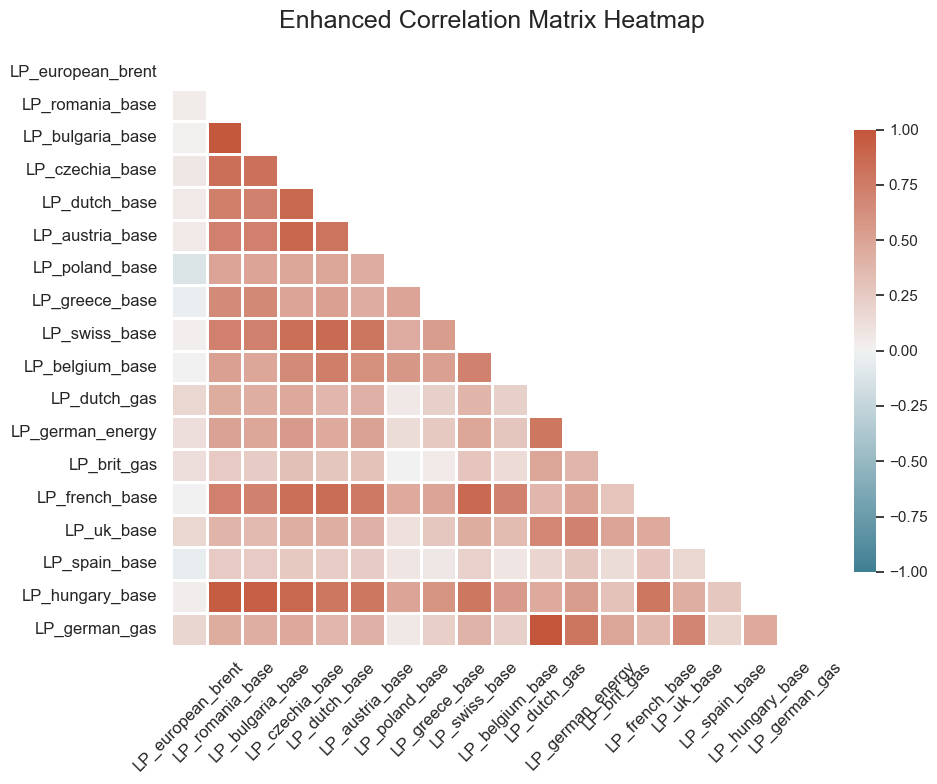

In [11]:
# Set the figure size and styling
plt.figure(figsize=(10, 8))
sns.set(style="white")  # Choose a clean, minimalistic style

# Mask the upper triangle of the heatmap for a cleaner look
mask = np.triu(np.ones_like(return_df.corr(), dtype=bool))

# Define a better color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create the heatmap with customization
sns.heatmap(return_df.corr(), 
            mask=mask,                 # Apply the mask
            cmap=cmap,                 # Use the custom color palette
            annot=True,                # Show annotations
            fmt=".2f",                 # Limit annotations to 2 decimal places
            annot_kws={"size": 12},     # Increase font size for annotations
            linewidths=1,               # Thicker gridlines for clarity
            linecolor='white',          # White grid lines
            cbar_kws={"shrink": 0.75},  # Shrink the color bar to fit better
            vmin=-1, vmax=1)            # Set a fixed color range for consistency

# Add title and improve axis labels
plt.title("Enhanced Correlation Matrix Heatmap", fontsize=18, pad=20)
plt.xticks(fontsize=12, rotation=45)  # Rotate x labels for readability
plt.yticks(fontsize=12)

# Display the heatmap
plt.tight_layout()
plt.savefig('Plots/correlation_matrix.png')

# Applying the Algorithms

In [17]:
return_df.dropna().values

array([[ 0.00396458, -0.01508369, -0.01515599, ...,  0.01280788,
        -0.01445619, -0.00914238],
       [ 0.01500592, -0.01818002, -0.01109224, ...,  0.02021185,
        -0.00383934,  0.05655907],
       [-0.02853067, -0.01881856, -0.02405012, ..., -0.01652717,
        -0.02549659, -0.09635121],
       ...,
       [ 0.0205232 ,  0.01255613,  0.00908628, ..., -0.01185061,
         0.01325143,  0.02363401],
       [ 0.01926073, -0.02044839, -0.02238492, ..., -0.06602059,
        -0.02381777, -0.02473751],
       [-0.00500208, -0.02204896, -0.02048722, ..., -0.01439689,
        -0.01499423,  0.01378164]])

In [18]:
# 1.
StandardizeTransform_ = StandardizeTransform()
StandardizeTransform_.fit(return_df.dropna().values)

data_trans = StandardizeTransform_.transform(return_df.dropna().values)

# 2.
data_obj = TimeSeriesData(data_trans, var_names=list(return_df.columns))

In [19]:
prior_knowledge = None #  PriorKnowledge(forbidden_links={'a': ['b']})

max_lag = 4
pvalue_thres=0.1
print(f'Using max_lag {max_lag}')

granger = Granger(
        data=data_obj,
        prior_knowledge=prior_knowledge,
        max_iter=10000, # number of optimization iterations for model fitting (default value is 1000)
        use_multiprocessing=False
        ) 

Using max_lag 4


In [20]:
tic = time.time()
result = granger.run(pvalue_thres=pvalue_thres, max_lag=max_lag)
toc = time.time()
print(f'Time taken: {toc-tic:.2f}s\n')

print(f' The output causal_strength has keys: {result.keys()}')

/Users/juliusgruber/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10312350641970625, tolerance: 0.06372735586524378
  model = cd_fast.enet_coordinate_descent_gram(
/Users/juliusgruber/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04479651316921718, tolerance: 0.04216667909547169
  model = cd_fast.enet_coordinate_descent_gram(
/Users/juliusgruber/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04759351496511499, tolerance: 0.04216667909547169
  model = cd_fast.enet_coordinate_descent_gram(
/Users/juliusgruber/anaconda3/lib/

Time taken: 18.24s

 The output causal_strength has keys: dict_keys(['LP_european_brent', 'LP_romania_base', 'LP_bulgaria_base', 'LP_czechia_base', 'LP_dutch_base', 'LP_austria_base', 'LP_poland_base', 'LP_greece_base', 'LP_swiss_base', 'LP_belgium_base', 'LP_dutch_gas', 'LP_german_energy', 'LP_brit_gas', 'LP_french_base', 'LP_uk_base', 'LP_spain_base', 'LP_hungary_base', 'LP_german_gas'])


# VarLingam
max_lag = 4
print(f'Using max_lag {max_lag}')

var_lingam = VARLINGAM(
        data=data_obj
        )
result = var_lingam.run(pvalue_thres=0.1, max_lag=max_lag)


# PCMCI 

In [21]:
prior_knowledge = None #  PriorKnowledge(forbidden_links={})

max_lag = 5
pvalue_thres = 0.05
print(f'Using max_lag {max_lag}')
#CI_test = PartialCorrelation()
CI_test = KCI(chunk_size=50) # use if the causal relationship is expected to be non-linear
pc = PC(
        data=data_obj,
        prior_knowledge=prior_knowledge,
        CI_test=CI_test,
        use_multiprocessing=False
        )

Using max_lag 5


In [23]:
result = pc.run(pvalue_thres=pvalue_thres, max_lag=max_lag)

print(f'Predicted parents:')
graph_est={n:[] for n in result.keys()}
for key in result.keys():
    parents = result[key]['parents']
    graph_est[key].extend(parents)
    print(f'{key}: {parents}')

Predicted parents:
LP_european_brent: []
LP_romania_base: []
LP_bulgaria_base: []
LP_czechia_base: []
LP_dutch_base: []
LP_austria_base: []
LP_poland_base: [('LP_poland_base', -1)]
LP_greece_base: []
LP_swiss_base: []
LP_belgium_base: []
LP_dutch_gas: []
LP_german_energy: []
LP_brit_gas: []
LP_french_base: []
LP_uk_base: []
LP_spain_base: []
LP_hungary_base: []
LP_german_gas: []


In [24]:
return_df.corr()

,LP_european_brent,LP_romania_base,LP_bulgaria_base,LP_czechia_base,LP_dutch_base,LP_austria_base,LP_poland_base,LP_greece_base,LP_swiss_base,LP_belgium_base,LP_dutch_gas,LP_german_energy,LP_brit_gas,LP_french_base,LP_uk_base,LP_spain_base,LP_hungary_base,LP_german_gas
LP_european_brent,1.000000,0.041583,0.014674,0.067466,0.050223,0.050446,-0.123366,-0.037384,0.017844,0.005062,0.170506,0.121942,0.124774,0.006227,0.169024,-0.054344,0.027734,0.173880
LP_romania_base,0.041583,1.000000,0.978632,0.829141,0.732360,0.726219,0.492658,0.653833,0.720780,0.520909,0.438882,0.505065,0.257191,0.724984,0.392949,0.254242,0.947488,0.440468
LP_bulgaria_base,0.014674,0.978632,1.000000,0.819755,0.717532,0.719514,0.498240,0.670185,0.715488,0.481594,0.434797,0.479927,0.235945,0.703275,0.353559,0.251514,0.932355,0.435980
LP_czechia_base,0.067466,0.829141,0.819755,1.000000,0.882781,0.884473,0.486088,0.497134,0.842934,0.652784,0.464486,0.554728,0.316372,0.828945,0.431174,0.264385,0.876611,0.463285
LP_dutch_base,0.050223,0.732360,0.717532,0.882781,1.000000,0.802815,0.488149,0.508379,0.855978,0.734409,0.369825,0.458887,0.273745,0.845041,0.432857,0.229526,0.784413,0.368595
LP_austria_base,0.050446,0.726219,0.719514,0.884473,0.802815,1.000000,0.445404,0.448424,0.794289,0.620810,0.419944,0.505748,0.311646,0.766059,0.417072,0.235717,0.784692,0.420611
LP_poland_base,-0.123366,0.492658,0.498240,0.486088,0.488149,0.445404,1.000000,0.493945,0.451105,0.572110,0.060070,0.135592,0.000616,0.460914,0.114737,0.080943,0.499885,0.061277
LP_greece_base,-0.037384,0.653833,0.670185,0.497134,0.508379,0.448424,0.493945,1.000000,0.537243,0.512099,0.218014,0.260389,0.052949,0.498204,0.266191,0.064777,0.598800,0.220695
LP_swiss_base,0.017844,0.720780,0.715488,0.842934,0.855978,0.794289,0.451105,0.537243,1.000000,0.707815,0.397166,0.478806,0.289012,0.869039,0.441012,0.208729,0.782964,0.399039
LP_belgium_base,0.005062,0.520909,0.481594,0.652784,0.734409,0.620810,0.572110,0.512099,0.707815,1.000000,0.210957,0.273588,0.140877,0.706722,0.343862,0.073841,0.557884,0.211422


# First Analysis on small dataset
In this section, we are doing our first experiment. We are analysisng the cross border effects of German Energy, German Gas, Dutch Gas and Dutch Energy prices.

In [25]:
def output_causal_relations_pcmci(returns_df, contracts, starting_preriod, end_preiod,pval_thresh,max_lag_input):
    new_returns_df = return_df[contracts].loc[starting_preriod:end_preiod]
    prior_knowledge = None #  PriorKnowledge(forbidden_links={})


    curr_df = new_returns_df
    
    StandardizeTransform_ = StandardizeTransform()
    StandardizeTransform_.fit(curr_df.dropna().values)
    
    data_trans = StandardizeTransform_.transform(curr_df.dropna().values)
    
    # 2.
    data_obj = TimeSeriesData(curr_df, var_names=list(curr_df.columns))
    
    
    
    data_trans = StandardizeTransform_.transform(curr_df.dropna().values)
    
    
    data_obj = TimeSeriesData(data_trans, var_names=list(curr_df.columns))
    max_lag = max_lag_input
    pvalue_thres = pval_thresh
    print(f'Using max_lag {max_lag}')
    CI_test = PartialCorrelation()
    # CI_test = KCI(chunk_size=100) # use if the causal relationship is expected to be non-linear
    pc = PC(
            data=data_obj,
            prior_knowledge=prior_knowledge,
            CI_test=CI_test,
            use_multiprocessing=False
            )

    result = pc.run(pvalue_thres=pvalue_thres, max_lag=max_lag)
    
    print(f'Predicted parents:')
    graph_est={n:[] for n in result.keys()}
    for key in result.keys():
        parents = result[key]['parents']
        graph_est[key].extend(parents)
        print(f'{key}: {parents}')
    return result, graph_est

In [26]:
small_analysis_contract = ['LP_german_energy', 'LP_german_gas','LP_dutch_base','LP_dutch_gas']

In [27]:
result, graph_est = output_causal_relations_pcmci(return_df, small_analysis_contract,'2021-01-01','2022-12-31',0.05,5)

Using max_lag 5
Predicted parents:
LP_german_energy: [('LP_german_energy', -3), ('LP_dutch_base', -5), ('LP_dutch_base', -1)]
LP_german_gas: [('LP_german_energy', -1), ('LP_german_gas', -3), ('LP_dutch_gas', -3), ('LP_dutch_gas', -2), ('LP_dutch_base', -5)]
LP_dutch_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2)]
LP_dutch_gas: [('LP_german_energy', -1), ('LP_german_gas', -3), ('LP_dutch_gas', -2), ('LP_dutch_gas', -3), ('LP_german_gas', -2), ('LP_dutch_base', -5)]


The above code presents up with some clear correlation pairs that are statistically significant patterns. We would like to validate the assumption that these are indeed predictive. We are going to do this by looking at a simple backtest to see wheter those patterns are indeed predictive.

# Validating the correlations

In [ ]:
# Function to check correlations for the given dictionary and dataframe
def check_lag_correlations(return_df, relations):
    correlations = {}
    
    for key, influences in relations.items():
        correlations[key] = {}
        for influencer, lag in influences:
            if influencer in return_df.columns and key in return_df.columns:
                # Shift the influencer's data by the specified lag
                shifted_series = return_df[influencer].shift(-lag)
                # Calculate the correlation
                correlation = return_df[key].corr(shifted_series)
                # Store the correlation
                correlations[key][f"{influencer}_lag{lag}"] = correlation
            else:
                correlations[key][f"{influencer}_lag{lag}"] = None  # Missing data warning
    
    return correlations

# Example usage
relations = {
    'LP_german_energy': [('LP_german_energy', -3),
                         ('LP_dutch_base', -5),
                         ('LP_dutch_base', -1)],
    'LP_german_gas': [('LP_german_energy', -1),
                      ('LP_german_gas', -3),
                      ('LP_dutch_gas', -3),
                      ('LP_dutch_gas', -2),
                      ('LP_dutch_base', -5)],
    'LP_dutch_base': [('LP_german_gas', -2), 
                      ('LP_dutch_gas', -2)],
    'LP_dutch_gas': [('LP_german_energy', -1),
                     ('LP_german_gas', -3),
                     ('LP_dutch_gas', -2),
                     ('LP_dutch_gas', -3),
                     ('LP_german_gas', -2),
                     ('LP_dutch_base', -5)]
}

# Assuming returns_df is your dataframe
correlation_results = check_lag_correlations(return_df, relations)

# Print the results
for key, correlation_dict in correlation_results.items():
    print(f"Correlations for {key}:")
    for lagged_influencer, corr_value in correlation_dict.items():
        print(f"  {lagged_influencer}: {corr_value}")


Correlations for LP_german_energy:
  LP_german_energy_lag-3: 0.03588555569435305
  LP_dutch_base_lag-5: -0.08080687986555062
  LP_dutch_base_lag-1: 0.13888731467209606
Correlations for LP_german_gas:
  LP_german_energy_lag-1: 0.13537753210020856
  LP_german_gas_lag-3: 0.04009513785844341
  LP_dutch_gas_lag-3: 0.032088598515902726
  LP_dutch_gas_lag-2: -0.08770166374406049
  LP_dutch_base_lag-5: -0.07662082581032449
Correlations for LP_dutch_base:
  LP_german_gas_lag-2: 0.14002666052309753
  LP_dutch_gas_lag-2: 0.12888438756677398
Correlations for LP_dutch_gas:
  LP_german_energy_lag-1: 0.12675851951546865
  LP_german_gas_lag-3: 0.04195847731883365
  LP_dutch_gas_lag-2: -0.08687718890181664
  LP_dutch_gas_lag-3: 0.03395678410993749
  LP_german_gas_lag-2: -0.0836038229569366
  LP_dutch_base_lag-5: -0.07518309815441443


We can indeed see corelations in the dataset.

# Signals Analysis

In [ ]:


def get_predictions_vs_actuals(returns_df, relations, train_start, train_end, test_start, test_end, clipping=False):
    """
    Get predictions from a linear regression model versus actuals.

    Parameters:
    - returns_df: DataFrame containing the returns.
    - relations: Dictionary of signals and their lags.
    - train_start: Start date of the training period.
    - train_end: End date of the training period.
    - test_start: Start date of the testing/backtesting period.
    - test_end: End date of the testing/backtesting period.
    - clipping: Boolean to apply winsorization (1st and 99th percentiles) to regression inputs.

    Returns:
    - results_df: DataFrame with predictions and actuals for each target.
    """
    # Ensure the DataFrame index is a DatetimeIndex
    if not isinstance(returns_df.index, pd.DatetimeIndex):
        returns_df = returns_df.copy()
        returns_df.index = pd.to_datetime(returns_df.index)
    
    # Prepare the lagged signals
    lagged_signals = pd.DataFrame(index=returns_df.index)
    
    for key, influences in relations.items():
        for influencer, lag in influences:
            if influencer in returns_df.columns:
                # Add the lagged signal
                lagged_signals[f"{influencer}_lag{lag}"] = returns_df[influencer].shift(-lag)
    
    # Combine the lagged signals with the target (key columns from relations)
    data = returns_df.copy()
    data = data.join(lagged_signals)
    
    # Split into training and testing sets
    train_data = data[train_start:train_end]
    test_data = data[test_start:test_end]
    
    # Prepare training inputs and outputs
    X_train = train_data[lagged_signals.columns].dropna()
    y_train = train_data.loc[X_train.index, relations.keys()]
    
    # Apply winsorization if clipping is True
    if clipping:
        lower_bound = X_train.quantile(0.01)
        upper_bound = X_train.quantile(0.99)
        X_train = X_train.clip(lower=lower_bound, upper=upper_bound, axis=1)
    
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Prepare test inputs and actuals
    X_test = test_data[lagged_signals.columns].dropna()
    y_test = test_data.loc[X_test.index, relations.keys()]
    
    # Apply winsorization to test data if clipping is True
    if clipping:
        lower_bound = X_test.quantile(0.01)
        upper_bound = X_test.quantile(0.99)
        X_test = X_test.clip(lower=lower_bound, upper=upper_bound, axis=1)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Create a results DataFrame
    results_df = pd.DataFrame(predictions, columns=[f"Predicted_{col}" for col in y_test.columns], index=X_test.index)
    for col in y_test.columns:
        results_df[f"Actual_{col}"] = y_test[col].values
    
    return results_df

# Example usage
relations = {
    'LP_german_energy': [('LP_german_energy', -3), ('LP_dutch_base', -5), ('LP_dutch_base', -1)],
    'LP_german_gas': [('LP_german_energy', -1), ('LP_german_gas', -3), ('LP_dutch_gas', -3), ('LP_dutch_gas', -2), ('LP_dutch_base', -5)],
    'LP_dutch_base': [('LP_german_gas', -2), ('LP_dutch_gas', -2)],
    'LP_dutch_gas': [('LP_german_energy', -1), ('LP_german_gas', -3), ('LP_dutch_gas', -2), ('LP_dutch_gas', -3), ('LP_german_gas', -2), ('LP_dutch_base', -5)]
}

# Assuming returns_df is your DataFrame with signals and returns
train_start = '2021-07-01'
train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-09-13'

# Apply clipping during regression
predictions_vs_actuals = get_predictions_vs_actuals(
    return_df.dropna(), relations, train_start, train_end, test_start, test_end, clipping=True
)

In [31]:
predictions_vs_actuals.head(3)

,Predicted_LP_german_energy,Predicted_LP_german_gas,Predicted_LP_dutch_base,Predicted_LP_dutch_gas,Actual_LP_german_energy,Actual_LP_german_gas,Actual_LP_dutch_base,Actual_LP_dutch_gas
Date,,,,,,,,
2024-01-02,-0.017405,-0.000046,-0.003553,-0.000122,-0.068348,-0.136774,0.255931,-0.140664
2024-01-03,0.049078,0.001046,0.001311,0.001227,0.077744,0.067827,0.038640,0.070391
2024-01-04,0.008924,0.030846,0.007552,0.030433,0.017617,0.023024,0.013717,0.027454


In [ ]:


def plot_predicted_vs_actual(df, columns_to_compare, save_path='plots/random.png'):
    """
    Plots predicted vs actual values with a scatter plot and a linear regression line.

    Parameters:
    - df1: DataFrame containing the first dataset.
    - df2: DataFrame containing the second dataset.
    - columns_to_compare: List of two column names to compare (e.g., ['Predicted', 'Actual']).

    Returns:
    - None. Displays the plot.
    """
    col2, col1  = columns_to_compare
    
    # Extract columns to compare
    x = df[col1].values
    y = df[col2].values
    
    # Ensure matching lengths
    min_len = min(len(x), len(y))
    x = x[:min_len]
    y = y[:min_len]
    
    # Linear regression
    x_reshaped = x.reshape(-1, 1)  # Reshape for sklearn
    reg = LinearRegression()
    reg.fit(x_reshaped, y)
    y_pred = reg.predict(x_reshaped)
    r2 = reg.score(x_reshaped, y)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.7, label="Data Points")
    plt.plot(x, y_pred, color="red", linewidth=2, label=f"Linear Fit: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}\nR² = {r2:.2f}")
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title("Predicted vs Actual")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

# Example usage (replace df1, df2, and column names with actual data)
# plot_predicted_vs_actual(df1, df2, ['Predicted', 'Actual'])


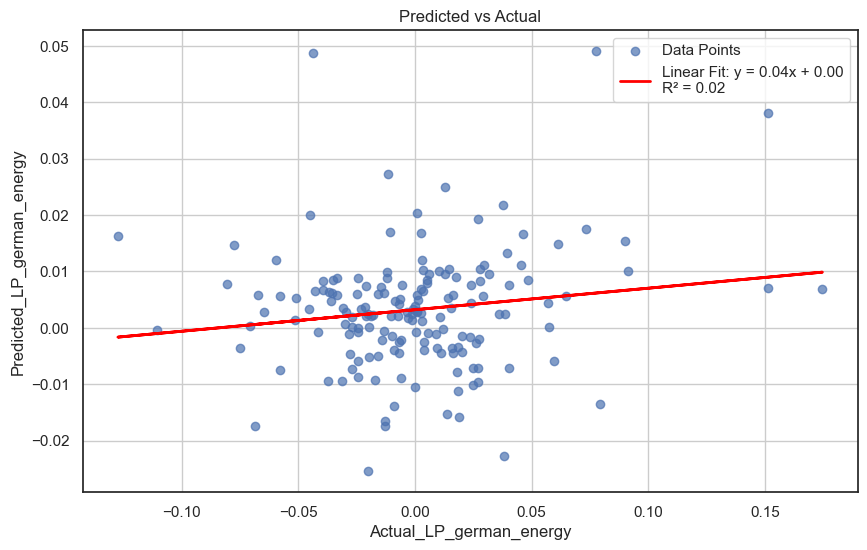

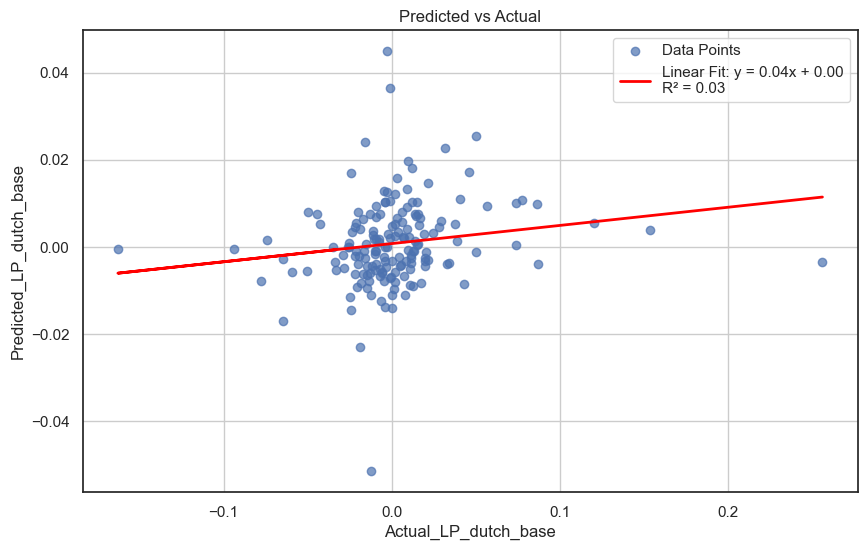

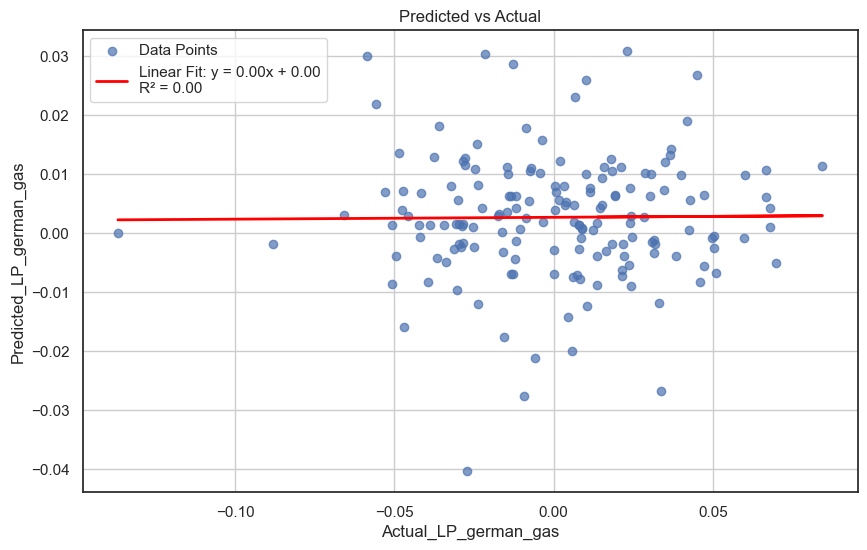

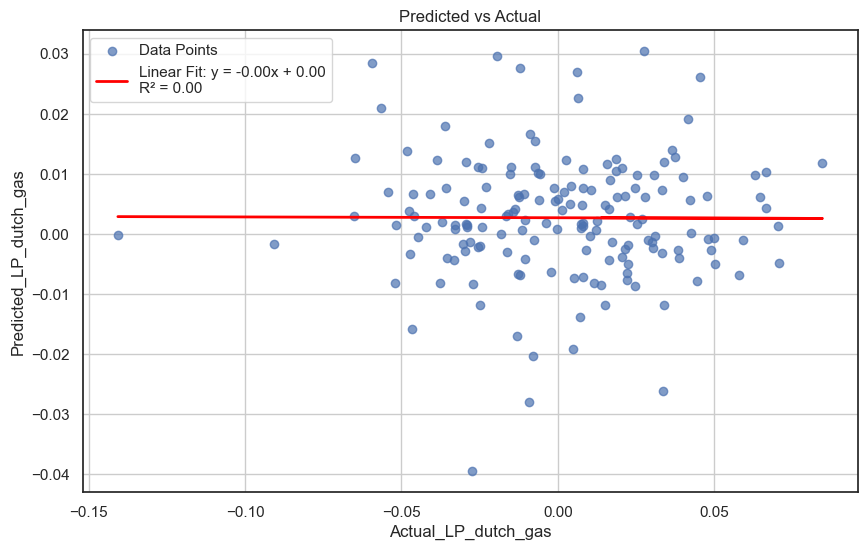

In [33]:
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_german_energy', 'Actual_LP_german_energy'],'Plots/small_german_energy.png')
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_dutch_base', 'Actual_LP_dutch_base'],'Plots/small_dutch_energy.png')
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_german_gas', 'Actual_LP_german_gas'],'Plots/small_german_gas.png')
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_dutch_gas', 'Actual_LP_dutch_gas'],'Plots/small_dutch_gas.png')

In [34]:
np.sum(predictions_vs_actuals[['Predicted_LP_german_energy']].values*predictions_vs_actuals[['Actual_LP_german_energy']].values > 0)/len(predictions_vs_actuals)

0.48484848484848486

In [35]:
np.sum(predictions_vs_actuals[['Predicted_LP_dutch_base']].values*predictions_vs_actuals[['Actual_LP_dutch_base']].values > 0)/len(predictions_vs_actuals)

0.593939393939394

In [36]:
np.sum(predictions_vs_actuals[['Predicted_LP_german_gas']].values*predictions_vs_actuals[['Actual_LP_german_gas']].values > 0)/len(predictions_vs_actuals)

0.47878787878787876

In [37]:
np.sum(predictions_vs_actuals[['Predicted_LP_dutch_gas']].values*predictions_vs_actuals[['Actual_LP_dutch_gas']].values > 0)/len(predictions_vs_actuals)

0.4666666666666667

In [38]:
predictions_vs_actuals[['Predicted_LP_dutch_gas']],predictions_vs_actuals[['Actual_LP_dutch_gas']]

(            Predicted_LP_dutch_gas
 Date                              
 2024-01-02               -0.000122
 2024-01-03                0.001227
 2024-01-04                0.030433
 2024-01-05               -0.002297
 2024-01-08               -0.001713
 2024-01-09               -0.039487
 2024-01-10               -0.000447
 2024-01-11                0.001758
 2024-01-12               -0.002773
 2024-01-15                0.012624
 2024-01-16               -0.027979
 2024-01-17                0.003026
 2024-01-18                0.026873
 2024-01-19                0.010395
 2024-01-22                0.006649
 2024-01-23               -0.006342
 2024-01-24                0.009789
 2024-01-25                0.012312
 2024-01-26               -0.011927
 2024-01-29                0.005479
 2024-02-01               -0.000977
 2024-02-02               -0.007127
 2024-02-05                0.001515
 2024-02-06               -0.002752
 2024-02-07                0.010004
 2024-02-08                0

In [40]:
print(mean_squared_error(predictions_vs_actuals[['Predicted_LP_dutch_gas']],predictions_vs_actuals[['Actual_LP_dutch_gas']]))
print(mean_absolute_error(predictions_vs_actuals[['Predicted_LP_dutch_gas']],predictions_vs_actuals[['Actual_LP_dutch_gas']]))

0.0012801693141107876
0.028771914274003225


In [41]:
predictions_vs_actuals.head(3)

,Predicted_LP_german_energy,Predicted_LP_german_gas,Predicted_LP_dutch_base,Predicted_LP_dutch_gas,Actual_LP_german_energy,Actual_LP_german_gas,Actual_LP_dutch_base,Actual_LP_dutch_gas
Date,,,,,,,,
2024-01-02,-0.017405,-0.000046,-0.003553,-0.000122,-0.068348,-0.136774,0.255931,-0.140664
2024-01-03,0.049078,0.001046,0.001311,0.001227,0.077744,0.067827,0.038640,0.070391
2024-01-04,0.008924,0.030846,0.007552,0.030433,0.017617,0.023024,0.013717,0.027454


# Results with more variables

In [74]:
return_df.head(3).columns

Index(['LP_european_brent', 'LP_romania_base', 'LP_bulgaria_base',
       'LP_czechia_base', 'LP_dutch_base', 'LP_austria_base', 'LP_poland_base',
       'LP_greece_base', 'LP_swiss_base', 'LP_belgium_base', 'LP_dutch_gas',
       'LP_german_energy', 'LP_brit_gas', 'LP_french_base', 'LP_uk_base',
       'LP_spain_base', 'LP_hungary_base', 'LP_german_gas'],
      dtype='object')

In [42]:
big_analysis_contract = ['LP_german_energy', 'LP_german_gas','LP_dutch_base','LP_dutch_gas','LP_poland_base', 'LP_austria_base', 'LP_czechia_base','LP_french_base']

In [43]:
result, graph_est = output_causal_relations_pcmci(return_df, big_analysis_contract,'2021-01-01','2022-12-31',0.05,5)

Using max_lag 5
Predicted parents:
LP_german_energy: [('LP_german_energy', -3)]
LP_german_gas: [('LP_german_energy', -1), ('LP_dutch_base', -2)]
LP_dutch_base: [('LP_dutch_base', -1), ('LP_german_gas', -2), ('LP_dutch_gas', -2)]
LP_dutch_gas: [('LP_german_energy', -1), ('LP_german_gas', -3), ('LP_dutch_gas', -2), ('LP_dutch_gas', -3), ('LP_dutch_base', -2), ('LP_german_gas', -2)]
LP_poland_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2)]
LP_austria_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2)]
LP_czechia_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2)]
LP_french_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2)]


In [75]:
result, graph_est = output_causal_relations_pcmci(return_df, return_df.columns,'2021-01-01','2022-12-31',0.05,5)

Using max_lag 5
Predicted parents:
LP_european_brent: [('LP_european_brent', -5), ('LP_romania_base', -5), ('LP_greece_base', -2), ('LP_spain_base', -4), ('LP_french_base', -4), ('LP_spain_base', -2)]
LP_romania_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2), ('LP_brit_gas', -3), ('LP_brit_gas', -1)]
LP_bulgaria_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2), ('LP_spain_base', -4), ('LP_dutch_base', -2), ('LP_brit_gas', -1)]
LP_czechia_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2), ('LP_brit_gas', -1), ('LP_dutch_gas', -1), ('LP_brit_gas', -3), ('LP_german_gas', -1)]
LP_dutch_base: [('LP_german_gas', -2), ('LP_brit_gas', -1), ('LP_brit_gas', -3), ('LP_dutch_gas', -2), ('LP_dutch_base', -1)]
LP_austria_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2), ('LP_brit_gas', -1), ('LP_dutch_gas', -1), ('LP_german_gas', -1), ('LP_brit_gas', -3)]
LP_poland_base: [('LP_german_gas', -2), ('LP_dutch_gas', -2), ('LP_german_energy', -5), ('LP_dutch_base', -1), ('LP_brit_gas', -3), ('LP_

In [76]:
# Assuming returns_df is your DataFrame with signals and returns
train_start = '2021-07-01'
train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-09-13'

# Apply clipping during regression
predictions_vs_actuals = get_predictions_vs_actuals(
    return_df.dropna(), graph_est, train_start, train_end, test_start, test_end, clipping=True
)

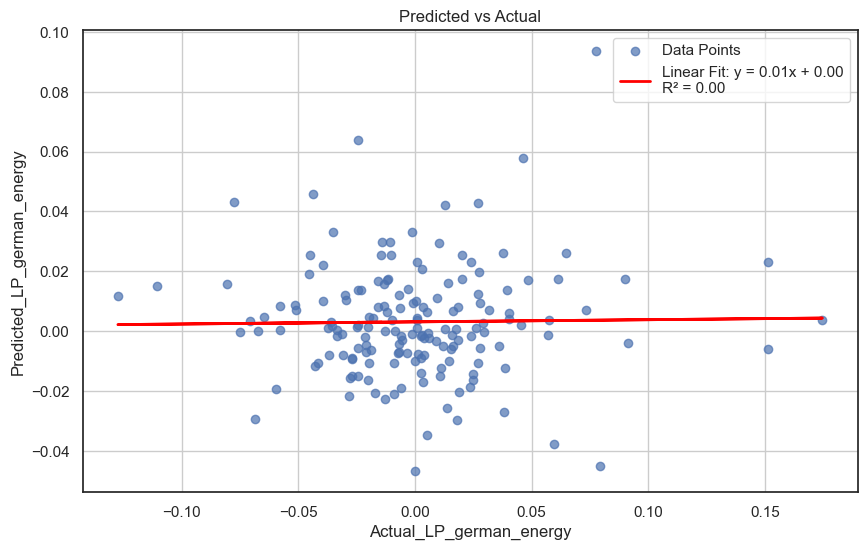

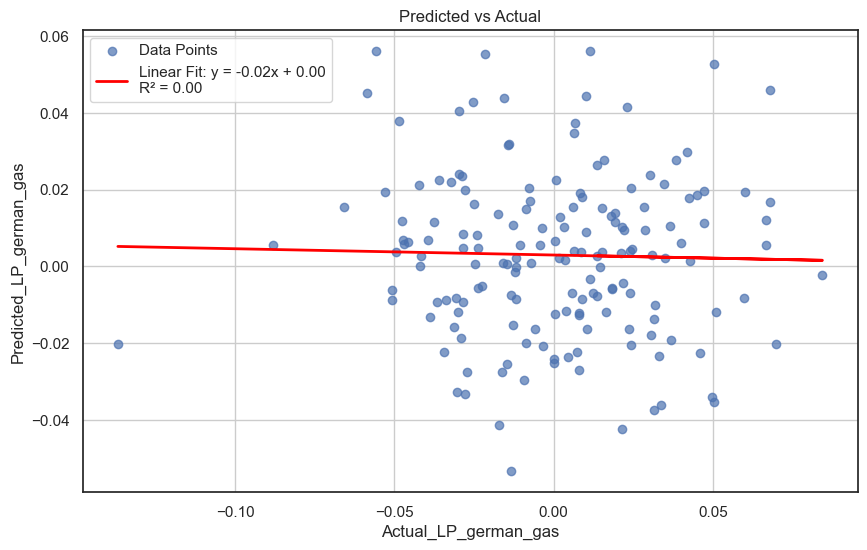

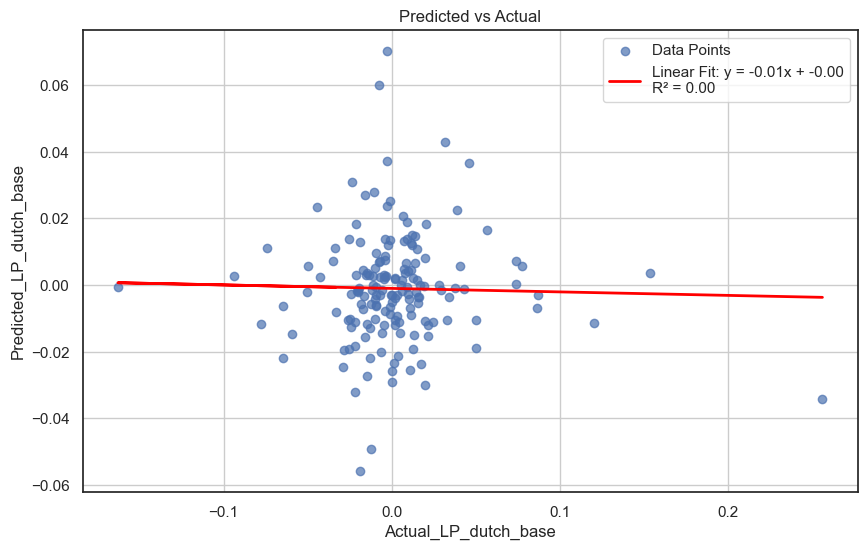

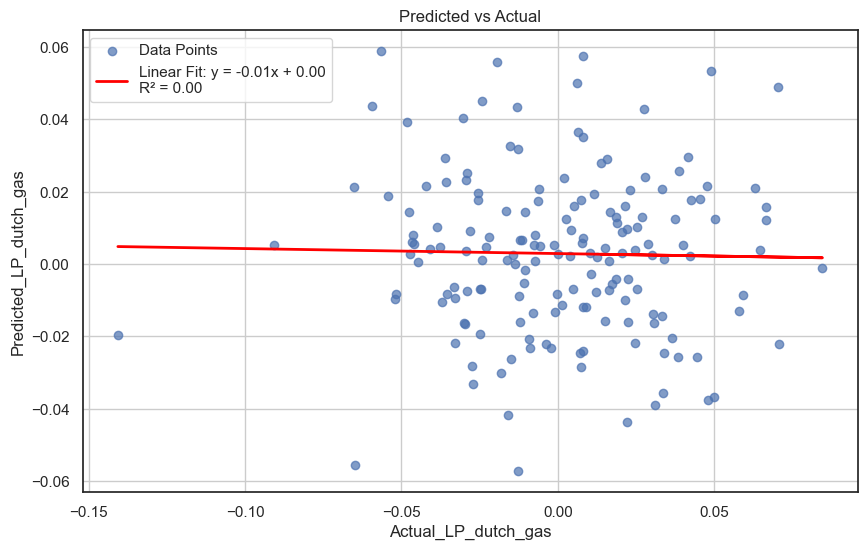

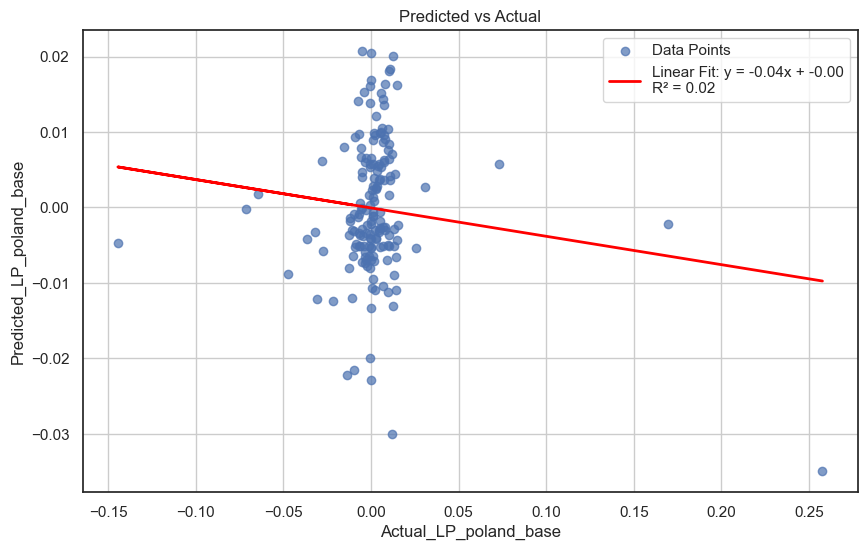

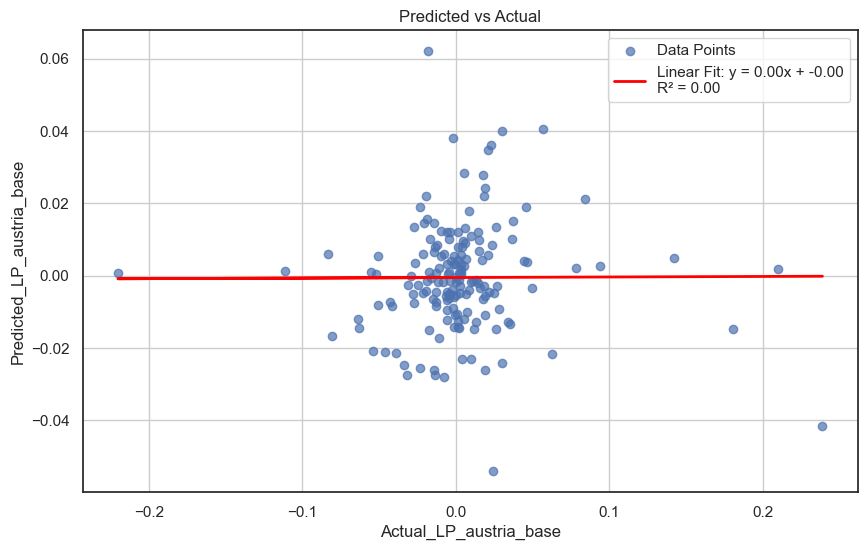

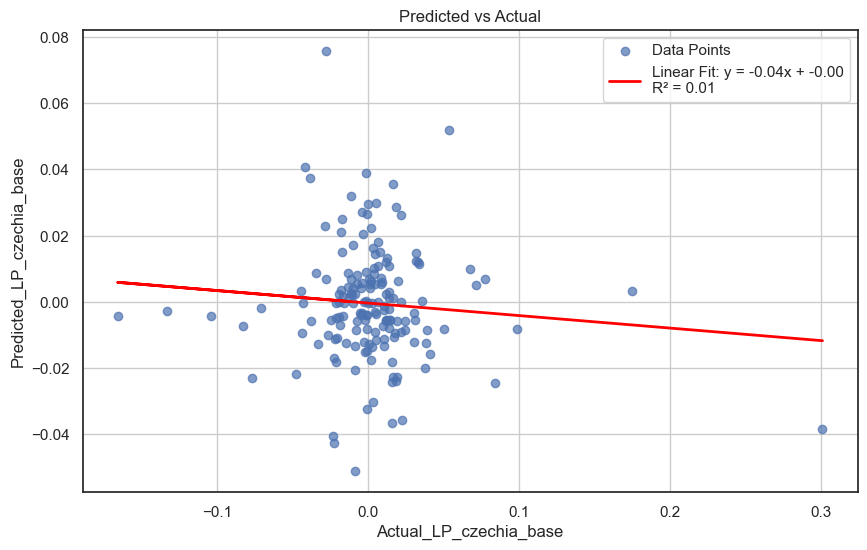

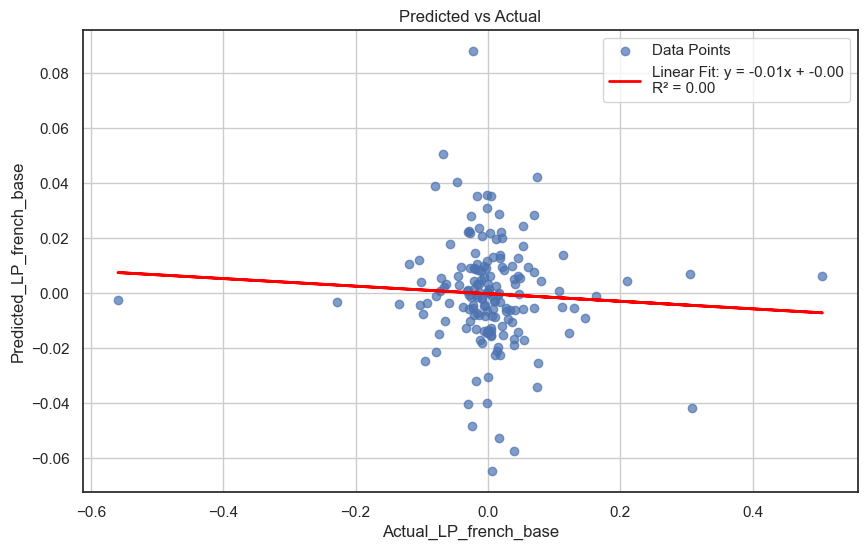

In [77]:
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_german_energy', 'Actual_LP_german_energy'])
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_german_gas', 'Actual_LP_german_gas'])
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_dutch_base', 'Actual_LP_dutch_base'])
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_dutch_gas', 'Actual_LP_dutch_gas'])
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_poland_base', 'Actual_LP_poland_base'])
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_austria_base', 'Actual_LP_austria_base'])
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_czechia_base', 'Actual_LP_czechia_base'])
plot_predicted_vs_actual(predictions_vs_actuals, ['Predicted_LP_french_base', 'Actual_LP_french_base'])

In [ ]:
def calculate_positive_prediction_ratio(predictions_vs_actuals, column_name):
    """
    Calculate the ratio of positive predictions where the predicted and actual values align.

    Parameters:
    - predictions_vs_actuals (pd.DataFrame): DataFrame containing predicted and actual values.
    - column_name (str): The column name for which the ratio is calculated (e.g., 'LP_german_energy').

    Returns:
    - float: The ratio of positive predictions aligning with actual values.
    """
    predicted_col = f"Predicted_{column_name}"
    actual_col = f"Actual_{column_name}"
    
    if predicted_col in predictions_vs_actuals.columns and actual_col in predictions_vs_actuals.columns:
        alignment = predictions_vs_actuals[predicted_col].values * predictions_vs_actuals[actual_col].values > 0
        ratio = np.sum(alignment) / len(predictions_vs_actuals)
        return ratio
    else:
        raise ValueError(f"Columns {predicted_col} or {actual_col} not found in the DataFrame.")

for column in predictions_vs_actuals.columns:
    if column.startswith("Predicted_"):
        base_column = column.replace("Predicted_", "")
        print(f"{base_column}:", calculate_positive_prediction_ratio(predictions_vs_actuals, base_column))

LP_european_brent: 0.5182926829268293
LP_romania_base: 0.5
LP_bulgaria_base: 0.5060975609756098
LP_czechia_base: 0.5060975609756098
LP_dutch_base: 0.5060975609756098
LP_austria_base: 0.5365853658536586
LP_poland_base: 0.5975609756097561
LP_greece_base: 0.7012195121951219
LP_swiss_base: 0.5365853658536586
LP_belgium_base: 0.5182926829268293
LP_dutch_gas: 0.5060975609756098
LP_german_energy: 0.4634146341463415
LP_brit_gas: 0.5304878048780488
LP_french_base: 0.4695121951219512
LP_uk_base: 0.5060975609756098
LP_spain_base: 0.5365853658536586
LP_hungary_base: 0.5
LP_german_gas: 0.49390243902439024


In [79]:
predictions_vs_actuals = predictions_vs_actuals[1:]

In [80]:
predictions_vs_actuals.head(3)

,Predicted_LP_european_brent,Predicted_LP_romania_base,Predicted_LP_bulgaria_base,Predicted_LP_czechia_base,Predicted_LP_dutch_base,Predicted_LP_austria_base,Predicted_LP_poland_base,Predicted_LP_greece_base,Predicted_LP_swiss_base,Predicted_LP_belgium_base,...,Actual_LP_swiss_base,Actual_LP_belgium_base,Actual_LP_dutch_gas,Actual_LP_german_energy,Actual_LP_brit_gas,Actual_LP_french_base,Actual_LP_uk_base,Actual_LP_spain_base,Actual_LP_hungary_base,Actual_LP_german_gas
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,0.024032,0.034669,0.033685,0.051969,0.022575,0.040517,0.020741,0.011157,0.025573,0.039053,...,0.046039,-0.003262,0.070391,0.077744,0.082009,0.073661,-0.005338,0.040535,0.020377,0.067827
2024-01-04,0.010219,-0.015094,-0.018431,-0.008605,0.014747,0.007832,-0.006472,-0.014475,0.006259,-0.013093,...,0.004659,-0.000117,0.027454,0.017617,0.068503,-0.009459,0.042810,-0.011725,-0.006523,0.023024
2024-01-05,0.002301,0.014551,0.009837,0.004624,0.004410,0.000464,0.004728,-0.006038,0.000703,0.019083,...,-0.008387,-0.001169,0.030351,-0.002971,-0.003417,-0.015322,0.044561,0.016966,-0.014545,0.031719


In [83]:
predictions_vs_actuals =  predictions_vs_actuals[predictions_vs_actuals.index!='2024-04-02']

In [ ]:
exclude : LP_european_brent, LP_dutch_gas, LP_german_gas, LP_brit_gas

In [ ]:
def financial_backtest_with_aggregate(df):
    """
    Perform a simple financial backtest for each pair of predicted and actual returns in the DataFrame.
    Strategy:
    - If predicted return > 0, go long (position = +1)
    - If predicted return < 0, go short (position = -1)
    Daily P&L = position * actual_return
    Cumulative_Return = (1 + Daily_PnL).cumprod()

    At the end, aggregate the daily P&L from all contracts to get an overall portfolio P&L.
    """

    # Ensure 'Date' is the index if present
    if 'Date' in df.columns:
        df = df.set_index('Date')

    # Identify predicted columns
    exclude_list = ['_european_brent', '_dutch_gas', '_german_gas', '_brit_gas']
    predicted_cols = [col for col in df.columns if col.startswith('Predicted_') and not any(col.endswith(exclude) for exclude in exclude_list)]

    results = {}
    daily_pnl_list = []

    for p_col in predicted_cols:
        # Find the corresponding actual column
        a_col = p_col.replace('Predicted_', 'Actual_')
        if a_col not in df.columns:
            continue

        predicted_values = df[p_col]
        actual_values = df[a_col]

        # Determine positions
        position = np.where(predicted_values > 0, 1, -1)

        # Daily PnL
        daily_pnl = position * actual_values.values

        # Create a DataFrame for this contract
        contract_name = p_col.replace('Predicted_', '')
        contract_df = pd.DataFrame({
            'Predicted': predicted_values,
            'Actual': actual_values,
            'Position': position,
            'Daily_PnL': daily_pnl,
        }, index=df.index)

        # Cumulative return for this contract
        contract_df['Cumulative_Return'] = (1 + contract_df['Daily_PnL']).cumprod()

        # Store result
        results[contract_name] = contract_df
        # Save daily PnL series to list for aggregation
        daily_pnl_list.append(contract_df['Daily_PnL'])

    # Aggregate Daily PnL across all contracts
    if daily_pnl_list:
        # Combine all contracts' PnL into one DataFrame and sum across columns
        aggregate_pnl = pd.concat(daily_pnl_list, axis=1).sum(axis=1)
        aggregate_cumulative = (1 + aggregate_pnl).cumprod()

        # Create an aggregate result DataFrame
        aggregate_results = pd.DataFrame({
            'Aggregate_Daily_PnL': aggregate_pnl,
            'Aggregate_Cumulative_Return': aggregate_cumulative
        })
    else:
        aggregate_results = pd.DataFrame()

    return results, aggregate_results

# Usage example:
results, aggregate_results = financial_backtest_with_aggregate(predictions_vs_actuals)
# print(aggregate_results.head())


Predicted_LP_romania_base
Predicted_LP_bulgaria_base
Predicted_LP_czechia_base
Predicted_LP_dutch_base
Predicted_LP_austria_base
Predicted_LP_poland_base
Predicted_LP_greece_base
Predicted_LP_swiss_base
Predicted_LP_belgium_base
Predicted_LP_german_energy
Predicted_LP_french_base
Predicted_LP_uk_base
Predicted_LP_spain_base
Predicted_LP_hungary_base


In [87]:
def financial_backtest_with_aggregate(df, trading_cost=0.000000):
    """
    Perform a simple financial backtest for each pair of predicted and actual returns in the DataFrame.
    Strategy:
    - If predicted return > 0, go long (position = +1)
    - If predicted return < 0, go short (position = -1)
    Daily PnL = (position * actual_return) - trading_cost
    Cumulative_Return = (1 + Daily_PnL).cumprod()

    At the end, aggregate the daily P&L from all contracts to get an overall portfolio P&L.

    trading_cost: fixed daily cost per contract.
    """

    # Ensure 'Date' is the index if present
    if 'Date' in df.columns:
        df = df.set_index('Date')

    # Identify predicted columns
    exclude_list = ['_european_brent', '_dutch_gas', '_german_gas', '_brit_gas']
    predicted_cols = [col for col in df.columns if col.startswith('Predicted_') and not any(col.endswith(exclude) for exclude in exclude_list)]

    results = {}
    daily_pnl_list = []

    for p_col in predicted_cols:
        # Find the corresponding actual column
        a_col = p_col.replace('Predicted_', 'Actual_')
        if a_col not in df.columns:
            continue

        predicted_values = df[p_col]
        actual_values = df[a_col]

        # Determine positions
        position = np.where(predicted_values > 0, 1, -1)

        # Daily PnL = position * actual_return - trading_cost
        # Apply the trading cost to each day regardless of position
        daily_pnl = (position * actual_values.values) - trading_cost

        # Create a DataFrame for this contract
        contract_name = p_col.replace('Predicted_', '')
        contract_df = pd.DataFrame({
            'Predicted': predicted_values,
            'Actual': actual_values,
            'Position': position,
            'Daily_PnL': daily_pnl,
        }, index=df.index)

        # Cumulative return for this contract
        contract_df['Cumulative_Return'] = (1 + contract_df['Daily_PnL']).cumprod()

        # Store result
        results[contract_name] = contract_df
        # Save daily PnL series for aggregation
        daily_pnl_list.append(contract_df['Daily_PnL'])

    # Aggregate Daily PnL across all contracts
    if daily_pnl_list:
        # Combine all contracts' PnL into one DataFrame and sum across columns
        aggregate_pnl = pd.concat(daily_pnl_list, axis=1).sum(axis=1)
        aggregate_cumulative = (1 + aggregate_pnl).cumprod()

        # Create an aggregate result DataFrame
        aggregate_results = pd.DataFrame({
            'Aggregate_Daily_PnL': aggregate_pnl,
            'Aggregate_Cumulative_Return': aggregate_cumulative
        })
    else:
        aggregate_results = pd.DataFrame()

    return results, aggregate_results

# Example usage:
results, aggregate_results = financial_backtest_with_aggregate(predictions_vs_actuals, trading_cost=0.0000)
# print(aggregate_results.head())


In [89]:

def financial_backtest_with_normalized_weights(df, trading_cost=0.00001):
    """
    Perform a financial backtest with normalized weights for long and short positions per day.
    Strategy:
    - Normalize long and short positions daily across all contracts so that their absolute sum equals 1.
    - Daily PnL = (normalized_position * actual_return) - trading_cost
    - Cumulative_Return = (1 + Daily_PnL).cumprod()

    trading_cost: fixed daily cost per contract.
    """

    # Ensure 'Date' is the index if present
    if 'Date' in df.columns:
        df = df.set_index('Date')

    # Identify predicted columns
    exclude_list = ['_european_brent', '_dutch_gas', '_german_gas', '_brit_gas']
    predicted_cols = [col for col in df.columns if col.startswith('Predicted_') and not any(col.endswith(exclude) for exclude in exclude_list)]

    results = {}
    daily_pnl_list = []

    # Prepare a DataFrame to store normalized positions for all contracts
    normalized_positions = pd.DataFrame(index=df.index)

    # Calculate raw positions for all contracts
    for p_col in predicted_cols:
        # Find the corresponding actual column
        a_col = p_col.replace('Predicted_', 'Actual_')
        if a_col not in df.columns:
            continue

        # Determine raw positions: +1 for long, -1 for short
        predicted_values = df[p_col]
        raw_position = np.where(predicted_values > 0, 1, -1)
        normalized_positions[p_col] = raw_position

    # Normalize positions daily across all contracts
    abs_sum_per_day = normalized_positions.abs().sum(axis=1)
    normalized_positions = normalized_positions.div(abs_sum_per_day, axis=0).fillna(0)

    # Backtest logic with normalized positions
    for p_col in predicted_cols:
        # Find the corresponding actual column
        a_col = p_col.replace('Predicted_', 'Actual_')
        if a_col not in df.columns:
            continue

        predicted_values = df[p_col]
        actual_values = df[a_col]

        # Use normalized positions
        position = normalized_positions[p_col]

        # Daily PnL = normalized_position * actual_return - trading_cost
        daily_pnl = (position * actual_values.values) - trading_cost

        # Create a DataFrame for this contract
        contract_name = p_col.replace('Predicted_', '')
        contract_df = pd.DataFrame({
            'Predicted': predicted_values,
            'Actual': actual_values,
            'Normalized_Position': position,
            'Daily_PnL': daily_pnl,
        }, index=df.index)

        # Cumulative return for this contract
        contract_df['Cumulative_Return'] = (1 + contract_df['Daily_PnL']).cumprod()

        # Store result
        results[contract_name] = contract_df
        # Save daily PnL series for aggregation
        daily_pnl_list.append(contract_df['Daily_PnL'])

    # Aggregate Daily PnL across all contracts
    if daily_pnl_list:
        # Combine all contracts' PnL into one DataFrame and sum across columns
        aggregate_pnl = pd.concat(daily_pnl_list, axis=1).sum(axis=1)
        aggregate_cumulative = (1 + aggregate_pnl).cumprod()

        # Create an aggregate result DataFrame
        aggregate_results = pd.DataFrame({
            'Aggregate_Daily_PnL': aggregate_pnl,
            'Aggregate_Cumulative_Return': aggregate_cumulative
        })
    else:
        aggregate_results = pd.DataFrame()

    return results, aggregate_results

# Example usage:
results, aggregate_results = financial_backtest_with_normalized_weights(predictions_vs_actuals, trading_cost=0.0001)
# print(aggregate_results.head())


In [94]:


def financial_backtest_with_market_neutral_positions(df, trading_cost=0.000000):
    """
    Perform a financial backtest with market-neutral positions (longs and shorts sum to 0 daily).
    Strategy:
    - Normalize long and short positions daily so that their sum equals 0 across all contracts.
    - Daily PnL = (position * actual_return) - trading_cost
    - Cumulative_Return = (1 + Daily_PnL).cumprod()

    trading_cost: fixed daily cost per contract.
    """

    # Ensure 'Date' is the index if present
    if 'Date' in df.columns:
        df = df.set_index('Date')

    # Identify predicted columns
    exclude_list = ['_european_brent', '_dutch_gas', '_german_gas', '_brit_gas']
    predicted_cols = [col for col in df.columns if col.startswith('Predicted_') and not any(col.endswith(exclude) for exclude in exclude_list)]

    results = {}
    daily_pnl_list = []

    # Initialize a DataFrame for storing positions and PnL for all contracts
    all_positions = pd.DataFrame(index=df.index)
    all_daily_pnl = pd.DataFrame(index=df.index)

    for p_col in predicted_cols:
        # Find the corresponding actual column
        a_col = p_col.replace('Predicted_', 'Actual_')
        if a_col not in df.columns:
            continue

        predicted_values = df[p_col]
        actual_values = df[a_col]

        # Determine raw positions: +1 for long, -1 for short
        raw_position = np.where(predicted_values > 0, 1, -1)

        # Add the raw positions to the all_positions DataFrame
        all_positions[p_col] = raw_position

    # Normalize positions per day to ensure they sum to 0 (market-neutral)
    for date in df.index:
        daily_positions = all_positions.loc[date]

        # Separate long and short positions
        long_positions = daily_positions[daily_positions > 0]
        short_positions = daily_positions[daily_positions < 0]

        # Scale long positions to sum to +0.5 and short positions to sum to -0.5
        if not long_positions.empty:
            long_positions /= long_positions.sum()
        if not short_positions.empty:
            short_positions /= -short_positions.sum()

        # Recombine normalized long and short positions
        normalized_positions = pd.concat([long_positions, short_positions]).sort_index()

        # Update the positions in the all_positions DataFrame
        all_positions.loc[date] = normalized_positions

    # Calculate daily PnL using normalized positions
    for p_col in predicted_cols:
        a_col = p_col.replace('Predicted_', 'Actual_')
        contract_positions = all_positions[p_col]
        actual_values = df[a_col]

        # Daily PnL = normalized_position * actual_return - trading_cost
        daily_pnl = (contract_positions * actual_values.values) - trading_cost
        all_daily_pnl[p_col] = daily_pnl

    # Calculate cumulative returns for each contract
    daily_pnl_list = []
    for p_col in predicted_cols:
        contract_pnl = all_daily_pnl[p_col]
        contract_cumulative_return = (1 + contract_pnl).cumprod()

        # Store results
        contract_name = p_col.replace('Predicted_', '')
        results[contract_name] = pd.DataFrame({
            'Predicted': df[p_col],
            'Actual': df[a_col],
            'Normalized_Position': all_positions[p_col],
            'Daily_PnL': contract_pnl,
            'Cumulative_Return': contract_cumulative_return,
        }, index=df.index)

        # Save daily PnL series for aggregation
        daily_pnl_list.append(contract_pnl)

    # Aggregate Daily PnL across all contracts
    if daily_pnl_list:
        # Combine all contracts' PnL into one DataFrame and sum across columns
        aggregate_pnl = pd.concat(daily_pnl_list, axis=1).sum(axis=1)
        aggregate_cumulative = (1 + aggregate_pnl).cumprod()

        # Create an aggregate result DataFrame
        aggregate_results = pd.DataFrame({
            'Aggregate_Daily_PnL': aggregate_pnl,
            'Aggregate_Cumulative_Return': aggregate_cumulative
        })
    else:
        aggregate_results = pd.DataFrame()

    return results, aggregate_results

# Example usage:
results, aggregate_results = financial_backtest_with_market_neutral_positions(predictions_vs_actuals, trading_cost=0.0001)
# print(aggregate_results.head())


/var/folders/x4/4mqqdmr15ns_x0tn1xzv7q5h0000gn/T/ipykernel_53344/3742980185.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07142857142857142' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_positions.loc[date] = normalized_positions
/var/folders/x4/4mqqdmr15ns_x0tn1xzv7q5h0000gn/T/ipykernel_53344/3742980185.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07142857142857142' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_positions.loc[date] = normalized_positions
/var/folders/x4/4mqqdmr15ns_x0tn1xzv7q5h0000gn/T/ipykernel_53344/3742980185.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07142857142857142' has dtype incompatible with i

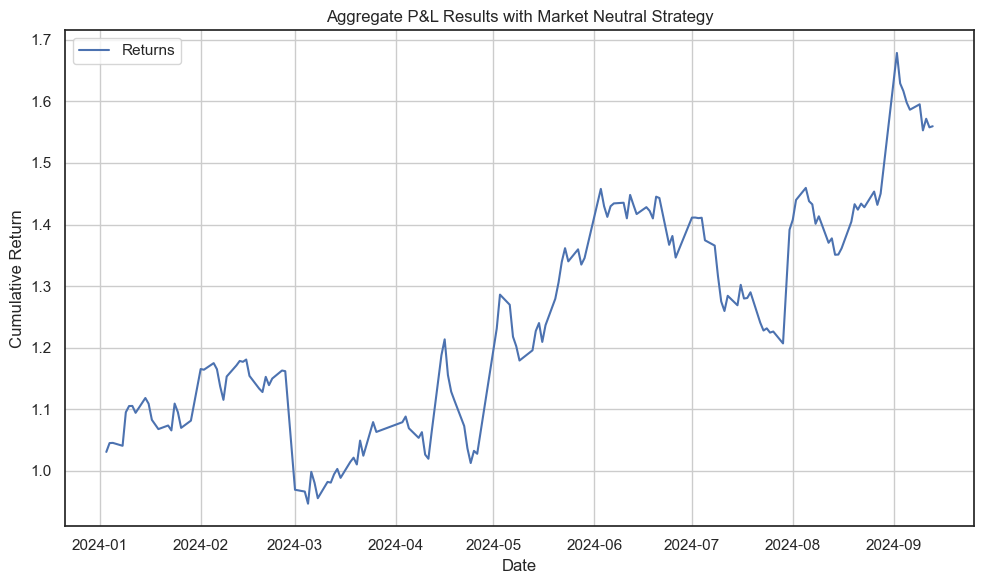

In [95]:
def plot_aggregate_cumulative_return(aggregate_results):
    """
    Plots a single graph of the aggregate cumulative returns from the backtest.
    """

    plt.figure(figsize=(10, 6))
    plt.plot(aggregate_results.index, aggregate_results['Aggregate_Cumulative_Return'], label='Returns')
    plt.title('Aggregate P&L Results with Market Neutral Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('Plots/BACKTESTINGRESULT.png')
    plt.show()

# Example usage:
# results, aggregate_results = financial_backtest_with_aggregate(predictions_vs_actuals)
plot_aggregate_cumulative_return(aggregate_results)


In [96]:
len(aggregate_results)

163

In [97]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio for a series of returns.

    Parameters:
    - returns (pd.Series): A series of returns.
    - risk_free_rate (float): The risk-free rate (default is 0.0).

    Returns:
    - sharpe_ratio (float): The Sharpe Ratio of the returns.
    """
    # Ensure returns is a pandas Series
    returns = pd.Series(returns)

    # Calculate the excess returns
    excess_returns = returns - risk_free_rate

    # Calculate the Sharpe Ratio
    sharpe_ratio = excess_returns.mean() / excess_returns.std()

    # Annualize if returns are daily
    sharpe_ratio_annualized = sharpe_ratio * np.sqrt(170)#/len(returns))  # 252 trading days in a year

    return sharpe_ratio_annualized


# Example usage
# Assume `daily_returns` is a pandas Series of daily returns from your backtest
daily_returns = aggregate_results['Aggregate_Daily_PnL']  # Replace with your actual returns series
sharpe_ratio = calculate_sharpe_ratio(daily_returns)
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Sharpe Ratio: 1.2202


In [98]:
def calculate_max_drawdown(cumulative_returns):
    """
    Calculate the maximum drawdown from a series of cumulative returns.

    Parameters:
    - cumulative_returns (pd.Series): Series of cumulative returns.

    Returns:
    - max_drawdown (float): Maximum drawdown as a percentage.
    - drawdown_duration (int): Duration of the maximum drawdown in trading days.
    """
    # Calculate the rolling maximum of cumulative returns
    rolling_max = cumulative_returns.cummax()

    # Calculate drawdown as the difference between the rolling max and the cumulative return
    drawdown = (cumulative_returns - rolling_max) / rolling_max

    # Find the maximum drawdown
    max_drawdown = drawdown.min()

    # Calculate drawdown duration
    end_of_drawdown = drawdown.idxmin()  # When the max drawdown occurred
    start_of_drawdown = (cumulative_returns[:end_of_drawdown] == rolling_max[:end_of_drawdown]).idxmax()
    drawdown_duration = (end_of_drawdown - start_of_drawdown).days

    return max_drawdown, drawdown_duration


In [ ]:
# Assuming `cumulative_returns` is your series of cumulative returns
cumulative_returns = aggregate_results['Aggregate_Cumulative_Return']  # Replace with your data

# Calculate maximum drawdown and duration
max_drawdown, drawdown_duration = calculate_max_drawdown(cumulative_returns)

print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Drawdown Duration: {drawdown_duration} days")


Maximum Drawdown: -17.54%
Drawdown Duration: 134 days
